<a href="https://colab.research.google.com/github/FuadKhalit/Natural-Language-Processing/blob/master/Loss_function_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# The Hyperparameter 
hyperparameter is important for tweaking & explore the impact on training

In [91]:
vocab_size = 3000 # original was10,000
embedding_dim = 16
max_length = 128 # original was 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

#original accuracy was 0.9938 but val_loss: 1.1478 - val_accuracy: 0.8106 (validation loss to high)
#This setting accuracy: 0.9052 - val_loss: 0.4463 - val_accuracy: 0.8289 (validation loss just nice)

In [92]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-07-02 13:40:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-07-02 13:40:35 (180 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [93]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [94]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [95]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [97]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

we use global average pooling 1d instead of flatten

In [98]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [99]:
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 128, 16)           48000     
_________________________________________________________________
global_average_pooling1d_9 ( (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 25        
Total params: 48,433
Trainable params: 48,433
Non-trainable params: 0
_________________________________________________________________


In [100]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.6802 - accuracy: 0.5603 - val_loss: 0.6574 - val_accuracy: 0.5634
Epoch 2/30
625/625 - 1s - loss: 0.5066 - accuracy: 0.7603 - val_loss: 0.4170 - val_accuracy: 0.8123
Epoch 3/30
625/625 - 1s - loss: 0.3647 - accuracy: 0.8420 - val_loss: 0.3780 - val_accuracy: 0.8322
Epoch 4/30
625/625 - 1s - loss: 0.3263 - accuracy: 0.8609 - val_loss: 0.3706 - val_accuracy: 0.8329
Epoch 5/30
625/625 - 1s - loss: 0.3063 - accuracy: 0.8688 - val_loss: 0.3621 - val_accuracy: 0.8422
Epoch 6/30
625/625 - 1s - loss: 0.2915 - accuracy: 0.8773 - val_loss: 0.3681 - val_accuracy: 0.8332
Epoch 7/30
625/625 - 1s - loss: 0.2803 - accuracy: 0.8819 - val_loss: 0.3896 - val_accuracy: 0.8225
Epoch 8/30
625/625 - 1s - loss: 0.2719 - accuracy: 0.8850 - val_loss: 0.3659 - val_accuracy: 0.8399
Epoch 9/30
625/625 - 1s - loss: 0.2649 - accuracy: 0.8881 - val_loss: 0.3750 - val_accuracy: 0.8359
Epoch 10/30
625/625 - 1s - loss: 0.2609 - accuracy: 0.8902 - val_loss: 0.3744 - val_accuracy: 0.8384

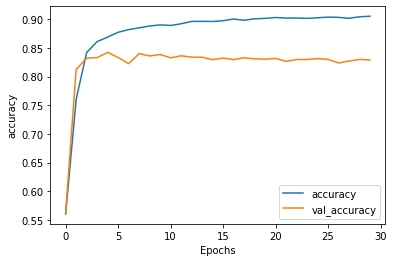

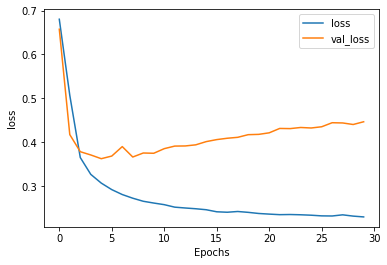

In [101]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [102]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store <OOV> sues over secret 'black <OOV> for minority <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [103]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(3000, 16)


In [104]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [105]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [106]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.975409  ]
 [0.04125113]]
